In [1]:
import os
import numpy
import time
import signal
import threading
import subprocess
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

from funtion_name import get_funtion

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

## 读取数据地址

In [2]:
data_dir = "../data_rec_mzpe"

In [3]:
# train_black_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "train")):
#     if "black" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             train_black_path.append(os.path.abspath(fp))

# train_white_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "train")):
#     if "white" in parent:
#         for filename in filenames:
#             fp = os.path.join(parent, filename)
#             train_white_path.append(os.path.abspath(fp))

# test_path = []
# for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "test")):
#     for filename in filenames:
#         fp = os.path.join(parent, filename)
#         test_path.append(os.path.abspath(fp))

real_path_new = []
for parent, dirnames, filenames in os.walk(os.path.join(data_dir, "real")):
    if "3_data_real" in parent:
        for filename in filenames:
            fp = os.path.join(parent, filename)
            real_path_new.append(os.path.abspath(fp))

In [4]:
len(real_path_new)

3010

In [3]:
# with open("train_black_path.pkl", 'wb') as f:
#     pickle.dump(train_black_path, f)

# with open("train_white_path.pkl", 'wb') as f:
#     pickle.dump(train_white_path, f)

# with open("test_path.pkl", 'wb') as f:
#     pickle.dump(test_path, f)

# with open("real_path.pkl", 'wb') as f:
#     pickle.dump(real_path, f)

with open("train_black_path.pkl", 'rb') as f:
    train_black_path = pickle.load(f)

with open("train_white_path.pkl", 'rb') as f:
    train_white_path = pickle.load(f)

with open("test_path.pkl", 'rb') as f:
    test_path = pickle.load(f)

with open("real_path.pkl", 'rb') as f:
    real_path = pickle.load(f)

In [6]:
# real_path += real_path_new

In [11]:
# with open("real_path.pkl", 'wb') as f:
#     pickle.dump(real_path, f)

In [4]:
len(real_path)

9017

拷贝一份

In [5]:
# if not os.path.exists("cfg"):
#     os.makedirs("cfg/black")
#     os.makedirs("cfg/white")
#     os.makedirs("cfg/test")
#     os.makedirs("cfg/real")

# for pt in train_black_path:
#     os.system("cp {0} {1}".format(pt, "cfg/black/"))
# for pt in train_white_path:
#     os.system("cp {0} {1}".format(pt, "cfg/white/"))
# for pt in test_path:
#     os.system("cp {0} {1}".format(pt, "cfg/test/"))
# for pt in real_path[6007:]:
#     os.system("cp {0} {1}".format(pt, "cfg/real/"))

train_black_path = [pt.replace("data_rec_mzpe/train/1_2000_", "jupyterlab/cfg/") for pt in train_black_path]
train_white_path = [pt.replace("data_rec_mzpe/train/1_4000_", "jupyterlab/cfg/") for pt in train_white_path]
test_path = [pt.replace("data_rec_mzpe/test/data", "jupyterlab/cfg/test") for pt in test_path]
real_path = [pt.replace("data_rec_mzpe/real/1_data_real", "jupyterlab/cfg/real") for pt in real_path]
real_path = [pt.replace("data_rec_mzpe/real/2_data_real", "jupyterlab/cfg/real") for pt in real_path]
real_path = [pt.replace("data_rec_mzpe/real/3_data_real", "jupyterlab/cfg/real") for pt in real_path]

In [14]:
empty = threading.Semaphore(value=20)
def convertToGdl(fp):
    ida = "/home/g3/yuri/idapro-7.4/idat64"
    idc = "/home/g3/yuri/idapro-7.4/idc/gen_fcg.idc"
    cmd = [ida, "-A", "-S{0}".format(idc), fp]
    p = subprocess.Popen(cmd,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE,
                         start_new_session=True,
                         shell=False,
                         close_fds=True)
    while True:
        if p.poll() is not None:
            break
        time.sleep(1)
    os.remove(fp)
    if os.path.exists(fp+'.i64'):
        os.remove(fp+'.i64')
    empty.release()

In [15]:
# with tqdm(total=6000, ncols=80, desc="gdl") as pbar:
#     for fp in train_black_path:
#         empty.acquire()
#         t = threading.Thread(target=convertToGdl, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)
#     for fp in train_white_path:
#         empty.acquire()
#         t = threading.Thread(target=convertToGdl, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)

# with tqdm(total=6000, ncols=80, desc="gdl_test") as pbar:
#     for fp in test_path:
#         empty.acquire()
#         t = threading.Thread(target=convertToGdl, args=(fp, ), daemon=True)
#         t.start()
#         pbar.update(1)

with tqdm(total=len(real_path[6007:]), ncols=80, desc="gdl_real") as pbar:
    for fp in real_path[6007:]:
        empty.acquire()
        t = threading.Thread(target=convertToGdl, args=(fp, ), daemon=True)
        t.start()
        pbar.update(1)

gdl_real: 100%|█████████████████████████████| 3010/3010 [15:27<00:00,  3.24it/s]


## 提取函数名

In [7]:
# train_fn, train_label = [], []

# test_data_fn = []

# with tqdm(total=6000*2, ncols=80, desc="fn") as pbar:
#     for fp in train_black_path:
#         pbar.update(1)
#         train_label.append(1)
#         if not os.path.exists(fp+'.gdl'):
#             train_fn.append(b"")
#             continue
#         fun_list = get_funtion(fp+'.gdl')
#         new_function_name = []
#         for fl in fun_list:
#             fn = fl[0]
#             if b"sub" not in fn and b"unknow" not in fn and b"@" not in fn:
#                 new_function_name.append(fn + (b' %d' % fl[2]))
#         train_fn.append(b" ".join(new_function_name))
#     for fp in train_white_path:
#         pbar.update(1)
#         train_label.append(0)
#         if not os.path.exists(fp+'.gdl'):
#             train_fn.append(b"")
#             continue
#         fun_list = get_funtion(fp+'.gdl')
#         new_function_name = []
#         for fl in fun_list:
#             fn = fl[0]
#             if b"sub" not in fn and b"unknow" not in fn and b"@" not in fn:
#                 new_function_name.append(fn + (b' %d' % fl[2]))
#         train_fn.append(b" ".join(new_function_name))
#     for fp in test_path:
#         pbar.update(1)
#         if not os.path.exists(fp+'.gdl'):
#             test_data_fn.append(b"")
#             continue
#         fun_list = get_funtion(fp+'.gdl')
#         new_function_name = []
#         for fl in fun_list:
#             fn = fl[0]
#             if b"sub" not in fn and b"unknow" not in fn and b"@" not in fn:
#                 new_function_name.append(fn + (b' %d' % fl[2]))
#         test_data_fn.append(b" ".join(new_function_name))

In [16]:
real_data_fn_new = []
with tqdm(total=len(real_path[6007:]), ncols=80, desc="gdl_real") as pbar:
    for fp in real_path[6007:]:
        pbar.update(1)
        if not os.path.exists(fp+'.gdl'):
            real_data_fn_new.append(b"")
            continue
        fun_list = get_funtion(fp+'.gdl')
        new_function_name = []
        for fl in fun_list:
            fn = fl[0]
            if b"sub" not in fn and b"unknow" not in fn and b"@" not in fn:
                new_function_name.append(fn + (b' %d' % fl[2]))
        real_data_fn_new.append(b" ".join(new_function_name))

gdl_real: 100%|█████████████████████████████| 3010/3010 [00:34<00:00, 88.27it/s]


In [6]:
# with open("cfg/train_fn.pkl", 'wb') as f:
#     pickle.dump(train_fn, f)

# with open("cfg/train_label.pkl", 'wb') as f:
#     pickle.dump(train_label, f)

# with open("cfg/test_data_fn.pkl", 'wb') as f:
#     pickle.dump(test_data_fn, f)

# with open("cfg/real_data_fn.pkl", 'wb') as f:
#     pickle.dump(real_data_fn, f)

with open("cfg/train_fn.pkl", 'rb') as f:
    train_fn = pickle.load(f)

with open("cfg/train_label.pkl", 'rb') as f:
    train_label = pickle.load(f)

with open("cfg/test_data_fn.pkl", 'rb') as f:
    test_data_fn = pickle.load(f)

with open("cfg/real_data_fn.pkl", 'rb') as f:
    real_data_fn = pickle.load(f)

In [ ]:
real_data_fn += real_data_fn_new
with open("cfg/real_data_fn.pkl", 'wb') as f:
    pickle.dump(real_data_fn, f)

In [19]:
len(train_fn), len(train_label), len(test_data_fn), len(real_data_fn)

(6000, 6000, 6000, 9017)

## TF-IDF

In [17]:
# vectorizer = TfidfVectorizer(ngram_range=(1, 5), min_df=3, max_df=0.9)

In [20]:
# with open("cfg/vectorizer.pkl", 'wb') as f:
#     pickle.dump(vectorizer, f)

with open("cfg/vectorizer.pkl", 'rb') as f:
    vectorizer = pickle.load(f)

In [21]:
train_fn_tfidf_features = vectorizer.transform(train_fn)
test_fn_tfidf_features = vectorizer.transform(test_data_fn)
real_fn_tfidf_features = vectorizer.transform(real_data_fn)

In [22]:
# with open("cfg/train_fn_tfidf_features.pkl", "wb") as fp:
#     pickle.dump(train_fn_tfidf_features, fp)

# with open("cfg/train_fn_tfidf_labels.pkl", "wb") as fp:
#     pickle.dump(train_label, fp)

# with open("cfg/test_fn_tfidf_features.pkl", "wb") as fp:
#     pickle.dump(test_fn_tfidf_features, fp)

with open("cfg/real_fn_tfidf_features.pkl", "wb") as fp:
    pickle.dump(real_fn_tfidf_features, fp)

with open("cfg/train_fn_tfidf_features.pkl", "rb") as fp:
    train_fn_tfidf_features = pickle.load(fp)

with open("cfg/train_fn_tfidf_labels.pkl", "rb") as fp:
    train_label = pickle.load(fp)
    
with open("cfg/test_fn_tfidf_features.pkl", "rb") as fp:
    test_tfidf_features = pickle.load(fp)

with open("cfg/real_fn_tfidf_features.pkl", "rb") as fp:
    real_fn_tfidf_features = pickle.load(fp)

In [23]:
train_fn_tfidf_features.shape, test_tfidf_features.shape, real_fn_tfidf_features.shape

((6000, 115680), (6000, 115680), (9017, 115680))

## 超参数

In [8]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
SEED = 4396

MAXLEN = 5000
BATCH_SIZE = 16
EPOCH = 300
SHUFFLE = False
CLASSES = 2

LR = 5e-5

## TEXT-CNN

In [9]:
train_fn = [fn.split(b' ') for fn in train_fn]
test_data_fn = [fn.split(b' ') for fn in test_data_fn]

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
# tokenizer.fit_on_texts(train_fn)

# with open("cfg/tokenizer.pkl", 'wb') as f:
#     pickle.dump(tokenizer, f)

with open("cfg/tokenizer.pkl", 'rb') as f:
    tokenizer = pickle.load(f)

word_index = tokenizer.word_index
WORD_SIZE = len(word_index) + 1


train_fn = tokenizer.texts_to_sequences(train_fn)
train_fn = tf.keras.preprocessing.sequence.pad_sequences(train_fn, maxlen=MAXLEN)

test_data_fn = tokenizer.texts_to_sequences(test_data_fn)
test_data_fn = tf.keras.preprocessing.sequence.pad_sequences(test_data_fn, maxlen=MAXLEN)

## 打乱顺序

In [8]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

features, labels = np.array(train_fn), np.array(train_label)
index = list(range(len(train_label)))
np.random.shuffle(index)
features = features[index]
labels = labels[index]

## 划分数据集

In [18]:
# 训练: 验证: 测试 = 8: 1: 1

train_features, test_features, train_label, test_label = train_test_split(
    features,
    labels,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED)
train_features, valid_features, train_label, valid_label = train_test_split(
    train_features,
    train_label,
    test_size=VAL_SIZE,
    stratify=train_label,
    random_state=SEED)

## 加载Dataset

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_features, valid_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_label)) \
                            .batch(BATCH_SIZE) \
                            .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

## 构建模型

In [20]:
inputs = layers.Input(shape=(MAXLEN, ), dtype='float32')
embedding_2 = layers.Embedding(WORD_SIZE, 64)(inputs)
Conv_2 = layers.Conv1D(100, 2, padding='same', activation='relu')(embedding_2)
max_pool_2_1 = layers.MaxPooling1D(2)(Conv_2)
conv_2_2 = layers.Conv1D(200, 2, padding="same", activation='relu')(max_pool_2_1)
max_pool_2_2 = layers.MaxPooling1D(2)(conv_2_2)
masking_2 = layers.Masking(0.)(max_pool_2_2)
lstm_2 = layers.LSTM(100, return_sequences=False)(masking_2)
# Flat = layers.Flatten()(Conv_2)
Dense_1 = layers.Dense(500, activation='relu')(lstm_2)
dropout = layers.Dropout(0.5)(Dense_1)
outputs = layers.Dense(1, activation='sigmoid')(dropout)

model = models.Model(inputs=inputs, outputs=outputs)

In [21]:
# 自定义评估指标
def score(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.int32)
    y_pred = tf.cast(tf.math.round(tf.reshape(y_pred, (-1,))), tf.int32)

    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), dtype=tf.float32))
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), dtype=tf.float32))
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0)), dtype=tf.float32))

    result = (tp/(tp+fn)) - 0.9*(fp/(fp+tn))
    
    return result

In [22]:
model.compile(optimizer=tf.keras.optimizers.Nadam(LR),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 5000, 64)          2896448   
_________________________________________________________________
conv1d (Conv1D)              (None, 5000, 100)         12900     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2500, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2500, 200)         40200     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1250, 200)         0         
_________________________________________________________________
masking (Masking)            (None, 1250, 200)         0     

## 训练

In [24]:
history = model.fit(
        train_ds,
        validation_data=valid_ds,
        # class_weight=class_weight_dict,
        epochs=EPOCH,
        workers=4,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4, mode='min'),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=0)])

Epoch 1/300
304/304 [==============================] - 31s 103ms/step - loss: 0.3439 - accuracy: 0.9126 - val_loss: 0.1317 - val_accuracy: 0.9685 - lr: 5.0000e-05
Epoch 2/300
304/304 [==============================] - 30s 98ms/step - loss: 0.1487 - accuracy: 0.9615 - val_loss: 0.1223 - val_accuracy: 0.9704 - lr: 5.0000e-05
Epoch 3/300
304/304 [==============================] - 29s 97ms/step - loss: 0.1393 - accuracy: 0.9630 - val_loss: 0.1083 - val_accuracy: 0.9722 - lr: 5.0000e-05
Epoch 4/300
304/304 [==============================] - 30s 97ms/step - loss: 0.1259 - accuracy: 0.9665 - val_loss: 0.0995 - val_accuracy: 0.9759 - lr: 5.0000e-05
Epoch 5/300
304/304 [==============================] - 30s 97ms/step - loss: 0.1199 - accuracy: 0.9675 - val_loss: 0.0987 - val_accuracy: 0.9741 - lr: 5.0000e-05
Epoch 6/300
304/304 [==============================] - 29s 97ms/step - loss: 0.1213 - accuracy: 0.9677 - val_loss: 0.0988 - val_accuracy: 0.9741 - lr: 5.0000e-05
Epoch 7/300
304/304 [======

In [25]:
dfhistory = pd.DataFrame(history.history)

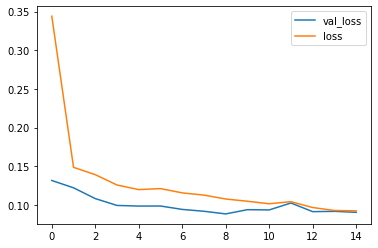

In [26]:
dfhistory[['val_loss', 'loss']].plot()

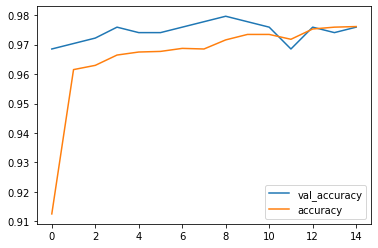

In [27]:
dfhistory[['val_accuracy', 'accuracy']].plot()

In [28]:
# dfhistory[['val_score', 'score']].plot()

## 测试集合

In [29]:
predict = model.evaluate(test_ds)

38/38 [==============================] - 1s 34ms/step - loss: 0.0716 - accuracy: 0.9833


In [30]:
# model.save('./cfg/cfg_0.9833.h5', save_format="tf")

## 测试数据

In [13]:
model = tf.keras.models.load_model('./cfg/cfg_0.9833.h5')

In [38]:
predict_test = model.predict(test_data_fn)

In [39]:
test_data_labels = [0 if v < 0.5 else 1 for v in predict_test]

In [40]:
sum(test_data_labels), len(test_data_labels)

(1898, 6000)

## 保存结果

In [33]:
# result = []
# for pt, label in zip(test_path, test_data_labels):
#     _, ha = os.path.split(pt)
#     result.append("{0}, {1}\n".format(ha, label))
# with open("./result/malware2.txt_{}_cfg_{}".format(time.strftime("%m-%d-%H:%M:%S", time.localtime()), 0.9817), 'w') as f:
#     f.write(''.join(result).strip())

## 输出模型结果

In [10]:
with open("cfg/train_fn.pkl", 'rb') as f:
    train_fn = pickle.load(f)

with open("cfg/train_label.pkl", 'rb') as f:
    train_label = pickle.load(f)

with open("cfg/test_data_fn.pkl", 'rb') as f:
    test_data_fn = pickle.load(f)

with open("cfg/real_data_fn.pkl", 'rb') as f:
    real_data_fn = pickle.load(f)

In [11]:
train_fn = [fn.split(b' ') for fn in train_fn]
test_data_fn = [fn.split(b' ') for fn in test_data_fn]
real_data_fn = [fn.split(b' ') for fn in real_data_fn]

with open("cfg/tokenizer.pkl", 'rb') as f:
    tokenizer = pickle.load(f)

word_index = tokenizer.word_index
WORD_SIZE = len(word_index) + 1
MAXLEN = 5000
    
train_fn = tokenizer.texts_to_sequences(train_fn)
train_fn = tf.keras.preprocessing.sequence.pad_sequences(train_fn, maxlen=MAXLEN)

test_data_fn = tokenizer.texts_to_sequences(test_data_fn)
test_data_fn = tf.keras.preprocessing.sequence.pad_sequences(test_data_fn, maxlen=MAXLEN)

real_data_fn = tokenizer.texts_to_sequences(real_data_fn)
real_data_fn = tf.keras.preprocessing.sequence.pad_sequences(real_data_fn, maxlen=MAXLEN)

In [14]:
cfg_textcnn_train = model.predict(train_fn)
cfg_textcnn_test = model.predict(test_data_fn)
cfg_textcnn_real = model.predict(real_data_fn)

In [15]:
cfg_textcnn_train.shape, cfg_textcnn_test.shape, cfg_textcnn_real.shape

((6000, 1), (6000, 1), (9017, 1))

In [16]:
with open("cfg/cfg_textcnn_train_old.csv", "wb") as fp:
    pickle.dump(cfg_textcnn_train, fp)
with open("cfg/cfg_textcnn_test_old.csv", "wb") as fp:
    pickle.dump(cfg_textcnn_test, fp)
with open("cfg/cfg_textcnn_real_old.csv", "wb") as fp:
    pickle.dump(cfg_textcnn_real, fp)

In [17]:
sum([0 if v < 0.5 else 1 for v in cfg_textcnn_test])

1856

In [18]:
sum([0 if v < 0.5 else 1 for v in cfg_textcnn_real])

2515